In [1]:
from math import exp, pi, log
import matplotlib.pyplot as plt
from graph_options import *

# 1. Constants

In [2]:
boltzman_const = 1.38 * 10**-23   # in J/K


# 2. Diffusion

## 2.1. Air dynamic viscosity

\begin{align}
\mu_g = 4.72 \times 10^{-8}\ T + 4.40 \times 10^{-6}
\end{align}

In [3]:
def dynamic_viscosity(temp):
    """Returns value of air dynamic viscosity in kg/m*s.
    Expects value of air temperature in Kelvin grade."""
    
    value = (4.72 * 10**-8) * temp + 4.40 * 10**-6   # in kg/m*s
    return value

## 2.2. Mean free path of air molecules

\begin{align}
\lambda = \frac{2.15 \times 10^{-4}\ \mu_g\ T^{\frac{1}{2}}}{P \times 10^{-5}}
\end{align}

In [4]:
def mean_free_path(temp, pres):
    """Returns value of air molecules mean free path.
    Expects values of temperaute in K and pressure in Pa."""
    
    viscosity_val = dynamic_viscosity(temp)
    
    value = (2.15 * 10**-4 * viscosity_val * temp**0.5) / (pres * 10**-5)
    return value

## 2.3. Knudsen number

\begin{align}
Kn = \frac{2\ \lambda}{d}
\end{align}

In [5]:
def Kn(temp, pres, diam):
    """Return value of Knudsen number.
    Expects values of temperaute in K, pressure in Pa and diameter in m."""
    
    value = 2 * mean_free_path(temp, pres) / diam
    return value

## 2.4. Cunningham slip correction factor

\begin{align}
C_c = 1 + 1.257\ Kn_p + 0.4\ Kn_p\ exp\Bigl(\frac{-0.55}{Kn_p}\Bigr)
\end{align}

In [6]:
def Cunningham_slip(temp, pres, part_diam):
    """Returns value of Cunningham slip correction factor.
    Expects  values of temperaute in K, pressure in Pa
    and particle diameter in m."""
    
    Kn_val = Kn(temp, pres, part_diam)
    
    value = (1 + 1.257 * Kn_val + 0.4 * Kn_val * exp(-0.55 / Kn_val))
    return value

## 2.5. Diffusion coefficient

\begin{align}
D = \frac{k_B\ T\ C_c}{3\ \pi\ \mu_g\ d_p}
\end{align}

In [7]:
def diffusion(temp, pres, part_diam):
    """Returns value of diffusion coefficient.
    Expects  values of temperaute in K, pressure in Pa
    and particle diameter in m."""
    
    viscosity_val = dynamic_viscosity(temp)
    Cunningham_val = Cunningham_slip(temp, pres, part_diam)
    
    value = ((boltzman_const * temp * Cunningham_val) / (3 * pi * viscosity_val * part_diam))
    return value

## 2.6. Peclet number

\begin{align}
Pe = \frac{U_g\ d_f}{D}
\end{align}

In [8]:
def Pe(temp, pres, part_diam, fibr_diam, gas_velo):
    """Returns value of Peclet number.
    Expects  values of temperaute in K, pressure in Pa,
    particle diameter in m, mean fibre diameter in m
    and gas velocity in m/s."""
    
    diffusion_val = diffusion(temp, pres, part_diam)
    
    value = gas_velo * fibr_diam / diffusion_val
    return value

## 2.7. Kuwabara number

\begin{align}
Ku = \frac{-ln(\alpha)}{2}-\frac{3}{4}+\alpha-\frac{\alpha^2}{4}
\end{align}

In [9]:
def Ku(pack_dens):
    """Returns value of Kuwabara number.
    Expects value of filter packing density."""
    
    value = (-log(pack_dens) / 2) - (3 / 4) + pack_dens - ((pack_dens**2) / 4)
    return value

## 2.8. Slip flow correction factor

\begin{align}
C_D = 1 + 0.388\ Kn_f\ \Bigl( \frac{(1-\alpha)\ Pe}{Ku} \Bigr)^{\frac{1}{3}}
\end{align}

In [10]:
def slip_flow_corr_dif(temp, pres, part_diam, fibr_diam, gas_velo, pack_dens):
    """Returns value of slip flow correction factor.
    Expects  values of temperaute in K, pressure in Pa,
    particle diameter in m, mean fibre diameter in m
    gas velocity in m/s and filter packing density."""
    
    Kn_val = Kn(temp, pres, fibr_diam)
    Pe_val = Pe(temp, pres, part_diam, fibr_diam, gas_velo)
    Ku_val = Ku(pack_dens)
    
    value = 1 + 0.388 * Kn_val * ((1 - pack_dens) * Pe_val / Ku_val)**(1/3)
    return value

## 2.9. Diffusion efficiency

\begin{align}
E_D = \frac{1.6\ \Bigl( \frac{(1-\alpha)}{Ku} \Bigr)^{\frac{1}{3}}\ Pe^{-\frac{2}{3}}\ C_D}{1 + 1.6\ \Bigl( \frac{(1-\alpha)}{Ku} \Bigr)^{\frac{1}{3}}\ Pe^{-\frac{2}{3}}\ C_D}
\end{align}

In [11]:
def diffusion_efficiency(temp, pres, part_diam, fibr_diam, gas_velo, pack_dens):
    """Returns value of filtration efficiency due to
    the diffusion mechanism.
    Expects  values of temperaute in K, pressure in Pa,
    particle diameter in m, mean fibre diameter in m
    gas velocity in m/s and filter packing density."""
    
    Ku_val = Ku(pack_dens)
    Pe_val = Pe(temp, pres, part_diam, fibr_diam, gas_velo)
    slip_corr_val = slip_flow_corr_dif(temp, pres, part_diam, fibr_diam, gas_velo, pack_dens)
    
    numerator = ((1.6 * ((1 - pack_dens) / Ku_val)**(1/3)) * (Pe_val**(-2/3)) * slip_corr_val)
    denominator = 1 + numerator
    value = numerator / denominator
    return value


# 3. Direct interception

## 3.1. Interception parameter

\begin{align}
R = \frac{d_p}{d_f}
\end{align}

In [12]:
def interception_param(part_diam, fibr_diam):
    """Returns value of interception parameter.
    Expects values of particle diameter in m
    and mean fibre diameter in m."""
    
    value = part_diam / fibr_diam
    return value

## 3.2. Slip flow correction factor

\begin{align}
C_{R} = 1 + \frac{1.996\ Kn_f}{R}
\end{align}

In [13]:
def slip_flow_corr_int(temp, pres, part_diam, fibr_diam):
    """Returns value of slip correction factor.
    Expects  values of temperaute in K, pressure in Pa,
    particle diameter in m and mean fibre diameter in m."""
    
    Kn_val = Kn(temp, pres, fibr_diam)
    R_val = interception_param(part_diam, fibr_diam)
    
    value = 1 + ((1.996 * Kn_val) / R_val)
    return value

## 3.3. Interception efficiency

\begin{align}
E_{R} = 0.6\ \Bigl(\frac{1-\alpha}{Ku}\Bigr)\ \Bigl(\frac{R^2}{1+R}\Bigr)\ C_{R}
\end{align}

In [14]:
def interception_efficiency(temp, pres, part_diam, fibr_diam, pack_dens):
    """Returns value of filtration efficiency due to
    the interception mechanism.
    Expects  values of temperaute in K, pressure in Pa,
    particle diameter in m, mean fibre diameter in m
    and filter packing density."""
    
    Ku_val = Ku(pack_dens)
    R_val = interception_param(part_diam, fibr_diam)
    C_val = slip_flow_corr_int(temp, pres, part_diam, fibr_diam)
    
    value = 0.6 * ((1 - pack_dens) / Ku_val) * (R_val**2 / (1 + R_val)) * C_val
    return value


# 4. Single fibre efficiency

\begin{align}
E = 1 - (1 - k_1 E_D)(1 - k_2 E_{R})
\end{align}

In [15]:
def fibre_efficiency(temp, pres, part_diam, fibr_diam, gas_velo, pack_dens, shape_const):
    """Returns single fibre filtration efficiency.
    Expects  values of temperaute in K, pressure in Pa,
    particle diameter in m, mean fibre diameter in m
    gas velocity in m/s, filter packing density
    and tuple with two shape-related, dimensionless constants."""
    
    difu_effi_val = shape_const[0] * diffusion_efficiency(temp, pres, part_diam, fibr_diam, gas_velo, pack_dens)
    inte_effi_val = shape_const[1] * interception_efficiency(temp, pres, part_diam, fibr_diam, pack_dens)
    
    value = 1 - (1 - difu_effi_val) * (1 - inte_effi_val)
    return value


# 5. Filtration efficiency

\begin{align}
\eta = 1 - exp\Bigl( \frac{-4\ \alpha\ E\ L}{\pi\ d_f\ (1 - \alpha)} \Bigr)
\end{align}

In [16]:
def efficiency(temp, pres, part_diam, fibr_diam, gas_velo, pack_dens, filt_thic, shape_const):
    """Returns single fibre filtration efficiency.
    Expects  values of temperaute in K, pressure in Pa,
    particle diameter in m, mean fibre diameter in m
    gas velocity in m/s, filter packing density, filter thickness in m
    and tuple with two shape-related dimensionless constants."""
    
    fibr_effi_val = fibre_efficiency(temp, pres, part_diam, fibr_diam, gas_velo, pack_dens, shape_const)
    
    value = 1 - exp((-4 * pack_dens * fibr_effi_val * filt_thic) / (pi * fibr_diam * (1 - pack_dens)))
    return value

# 6. Run experiments

## 6.1. Particle sizes

In [17]:
particles_liquid = [15, 20, 30, 45, 70, 100, 150, 250]   # in nm
particles_solid = [20, 30, 45, 70, 100]   # in nm

## 6.2. Particle morphology
Two dimensionless constants which depends on the particle shape:
  * ratio of the actual particle surface area and surface area of volume equivalent spherical particle
  * ratio of the projected area of particle and projected area of volume equivalent spherical particle

For spherical particles both constants are equal to 1.

In [18]:
particles_morph_spherical = {15 : (1, 1), 20 : (1, 1), 30 : (1, 1), 45 : (1, 1), 70 : (1, 1),
                    100 : (1, 1), 150 : (1, 1),  250: (1, 1)}
particles_morph_agglomerates = {20 : (1.029, 0.893), 30 : (1.095, 1.473), 45 : (1.238, 1.967), 70 : (1.699, 3.080),
                    100 : (2.038, 3.821)}

## 6.3. Define experiments
Experiments are defined as dictionaries where process parameters are given
as values for the following keys:  
  * tag - experiment identifier (string, e.g. "Filter 1")  
  * mark - marker colour and type (string, e.g. "ro-", "gs--")  
  * temp - air temperature in K (float, e.g. 20 + 273.15)  
  * pres - air pressure in Pa (float, e.g. 101325)  
  * velo - gas velocity in m/s (float, e.g. 0.1)  
  * fibr - filter mean fibres diameter in m (float, e.g. 1 * 10**-6)  
  * pack - filter packing density (float, e.g. 0.05)
  * thick - filter thicksness in m (float, e.g. 1 * 10**-3)

In [19]:
exp1 = {"tag" : "spherical",
        "mark" : "ko:",
        "temp" : 23 + 273.15,
        "pres" : 101010,
        "velo" : 0.078,
        "fibr" : 0.35 * 10**-6,
        "pack" : 0.0018,
        "thic" : 1 * 10**-3,
        "size" : particles_liquid,
        "shape" : particles_morph_spherical}

exp2 = {"tag" : "agglomerates",
        "mark" : "C7d--",
        "temp" : 23 + 273.15,
        "pres" : 101010,
        "velo" : 0.078,
        "fibr" : 0.35 * 10**-6,
        "pack" : 0.0018,
        "thic" : 1 * 10**-3,
        "size" : particles_solid,
        "shape" : particles_morph_agglomerates}

experiments = [exp1, exp2]

## 6.4. Save figure

In [20]:
save_figure = True
figure_name = "filtration_model_agglomerates.png"
legend_location = "upper right"

## 6.5. Calculations

spherical
15 nm : 97.42%
20 nm : 95.48%
30 nm : 90.64%
45 nm : 83.18%
70 nm : 74.11%
100 nm : 68.78%
150 nm : 67.42%
250 nm : 73.8%

agglomerates
20 nm : 95.85%
30 nm : 92.68%
45 nm : 89.75%
70 nm : 91.78%
100 nm : 93.76%



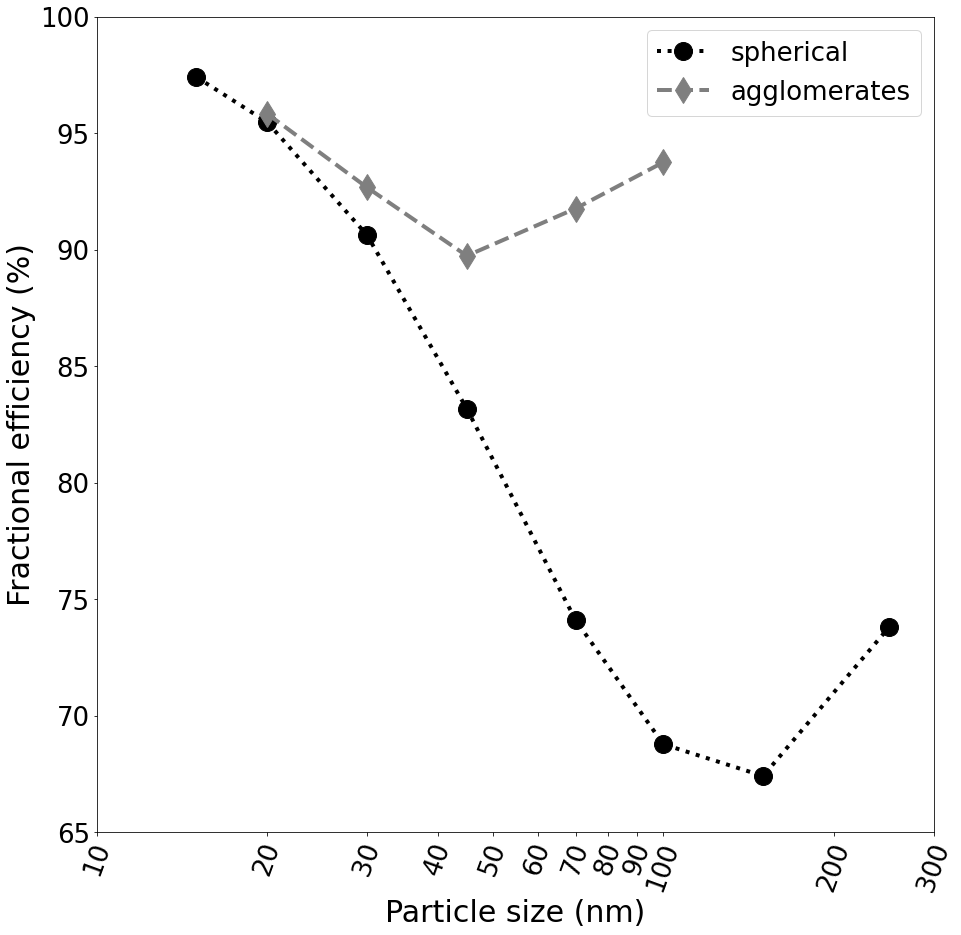

In [21]:
plt.rcParams["figure.figsize"] = 15,15
plt.tick_params(axis="both", which="both", labelsize = label_font - 4)
plt.gca().set_xscale("log")
plt.xlabel("Particle size (nm)", fontsize = label_font)
plt.ylabel("Fractional efficiency (%)", fontsize = label_font)
plt.axis([10, 300, 65, 100])
plt.xticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300],
           labels = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300],
           rotation = 70)

for experiment in experiments:
    efficiencies = []
    
    for size in experiment["size"]:
        efficiencies.append(efficiency(experiment["temp"], experiment["pres"], size * 10**-9,
                                       experiment["fibr"], experiment["velo"],
                                       experiment["pack"], experiment["thic"],
                                       experiment["shape"][size]) * 100)

    plt.plot(experiment["size"], efficiencies, experiment["mark"], linewidth = line_width,
             markersize = marker_size, label=experiment["tag"])
    
    print(experiment["tag"])
    for i in range(len(experiment["size"])):
        print(str(experiment["size"][i]) + " nm : " + str(round(efficiencies[i], 2)) + "%")
    print()

plt.legend(loc = legend_location, fontsize = label_font - 4)
if save_figure:
    plt.savefig(figure_name)
plt.show()